In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

from data.data import TRANSFORM, create_angle_features
from pose.utils import TESTPATH, CLASS_MAPPINGS_NAMES, LANDMARKS_ANGLES_DICT, LANDMARK_DICT, calc_limb_lengths
from pose.plot import plot_image, plot_3d_keypoints, plot_distribution_with_image
from pose.pose import pose_landmarks_to_list, estimate_poses
from classifier.classify import classify_image
from pose.baseline import get_angle_confidence_intervals, create_pose_df, warrior_pose_front_back, \
get_annotated_img, compare_two_figures, select_correct_closest_image, which_leg_front
from gan.run_cLimbGAN import generate_coords_given_limb_lengths

### Read in Image

In [3]:
# Note that these images are all unseen by the system in training (ie test images) 
# But we have manually classified them as bad images & therefore in need of correction

In [4]:
# TODO Make it so they can select an image or they can read in one at random
# "/0_downwardDog/sddefault.jpg"
# "/0_warrior2/Ashton-warrior-2-wrong.jpg"
PATH = "/0_warrior1/Crescent+Lunge+1.jpg"
EXAMPLE_PATH = str(TESTPATH)+PATH

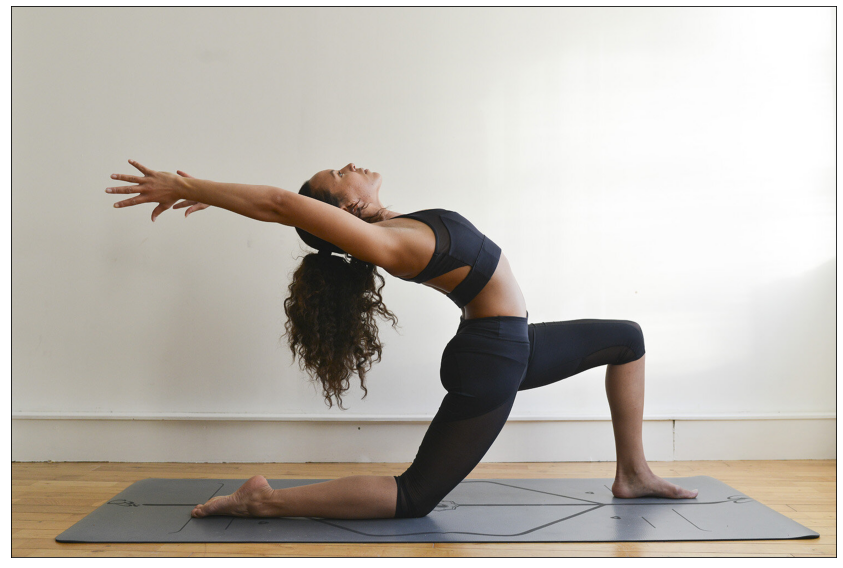

In [5]:
test_image = TRANSFORM(Image.open(EXAMPLE_PATH))
plot_image(test_image, dataloader=True)

### Apply Pose Estimation

In [6]:
test_result, annotated_test_image = estimate_poses(test_image, PATH, skip_image_annotation=False)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


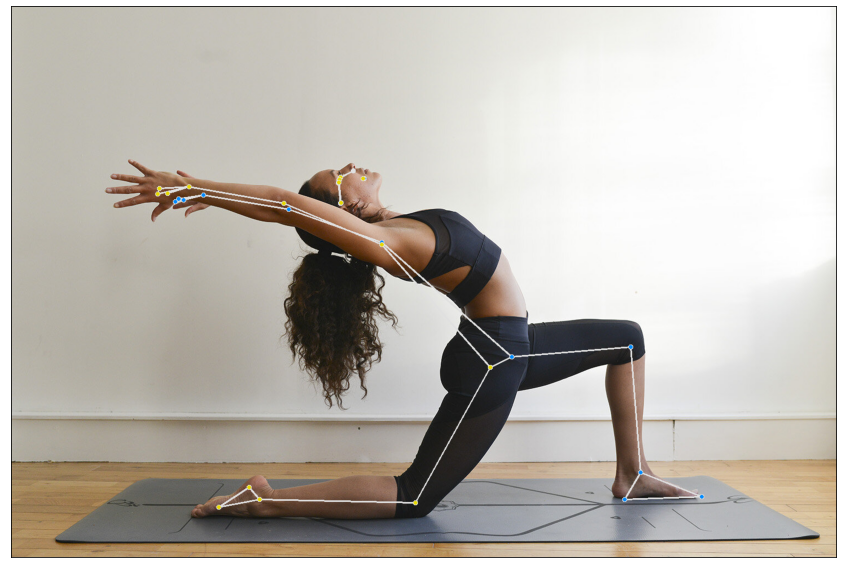

In [7]:
plot_image(annotated_test_image, dataloader=False)

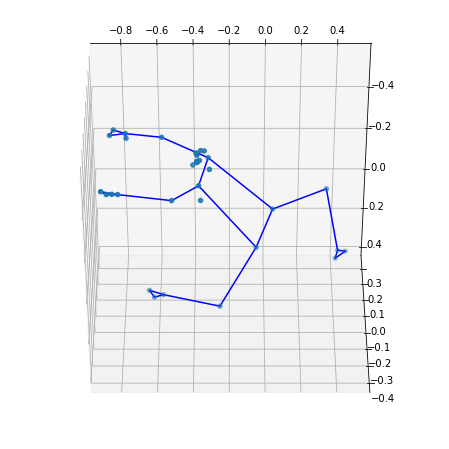

In [8]:
val, _, nump = pose_landmarks_to_list(test_result, 'pose_world_landmarks')

df_test = pd.DataFrame.from_records([val]).rename(LANDMARK_DICT, axis=1)
create_angle_features(df_test)

np_test = np.array([nump])

x = np_test[0].T[0]
y = np_test[0].T[1]
z = np_test[0].T[2]

plot_3d_keypoints(x, y, z, -50, 270)

### Pose Classification

In [9]:
label = classify_image(np_test).item()
print(f"Image Classified as : {CLASS_MAPPINGS_NAMES[label]}")

Image Classified as : W2


In [10]:
df_w1, df_w2, df_dd = create_pose_df()

if label == 0:
    df = df_dd
    LANDMARKS = LANDMARKS_ANGLES_DICT.keys()
elif label == 1:
    df, LANDMARKS = warrior_pose_front_back(df_w1)
    df_test = which_leg_front(df_test)
elif label == 2:
    df, LANDMARKS = warrior_pose_front_back(df_w2)
    df_test = which_leg_front(df_test)

We calculated that the LEFT foot is the forward foot.


# Pose Correction

### Learned Angle Distributions

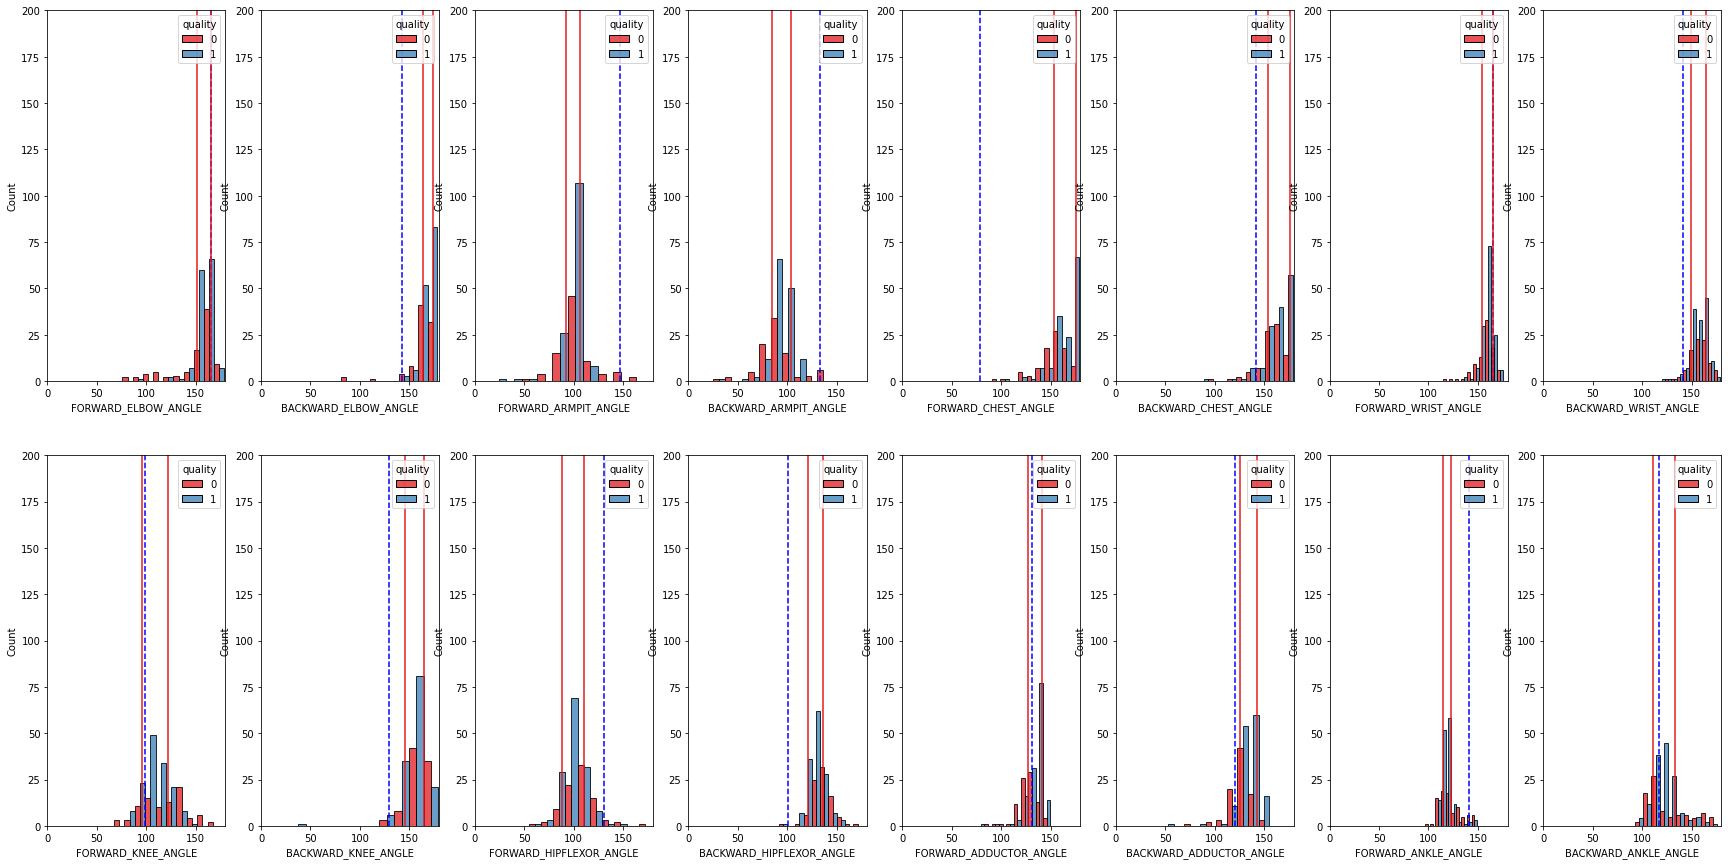

BACKWARD_ELBOW_ANGLE is to small by - 21.3 degrees
FORWARD_ARMPIT_ANGLE is to large by - 41.1 degrees
BACKWARD_ARMPIT_ANGLE is to large by - 29.9 degrees
FORWARD_CHEST_ANGLE is to small by - 74.7 degrees
BACKWARD_CHEST_ANGLE is to small by - 12.1 degrees
FORWARD_WRIST_ANGLE is to large by - 0.0 degrees
BACKWARD_WRIST_ANGLE is to small by - 8.6 degrees
BACKWARD_KNEE_ANGLE is to small by - 16.7 degrees
FORWARD_HIPFLEXOR_ANGLE is to large by - 20.3 degrees
BACKWARD_HIPFLEXOR_ANGLE is to small by - 20.6 degrees
BACKWARD_ADDUCTOR_ANGLE is to small by - 5.0 degrees
FORWARD_ANKLE_ANGLE is to large by - 18.7 degrees


In [11]:
distribution_angles = get_angle_confidence_intervals(df, LANDMARKS, percent = .15)
plot_distribution_with_image(df, df_test, distribution_angles, LANDMARKS)

### 3D Limbs & Angles

In [12]:
ground_truth, ground_truth_indx = select_correct_closest_image(np_test, df)
ground_truth_img = get_annotated_img(ground_truth_indx)

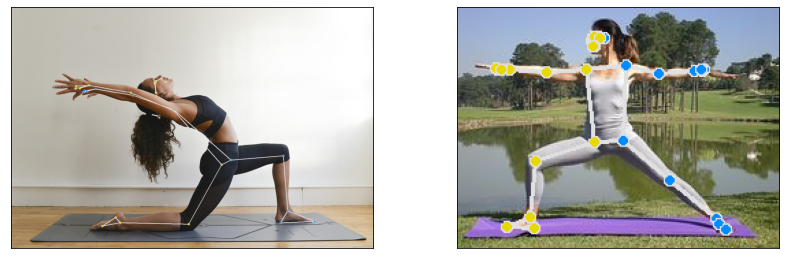

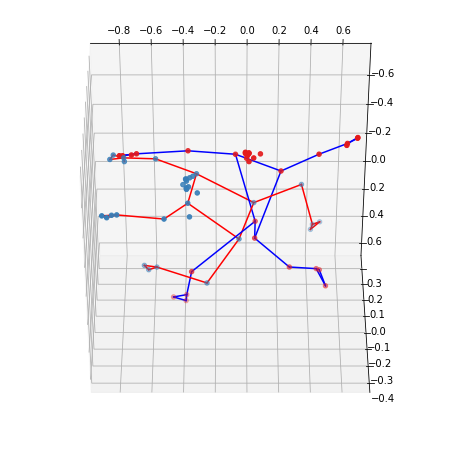

In [13]:
compare_two_figures(np.squeeze(np_test), np.squeeze(ground_truth), annotated_test_image, ground_truth_img, plot=True)

### GAN Correction

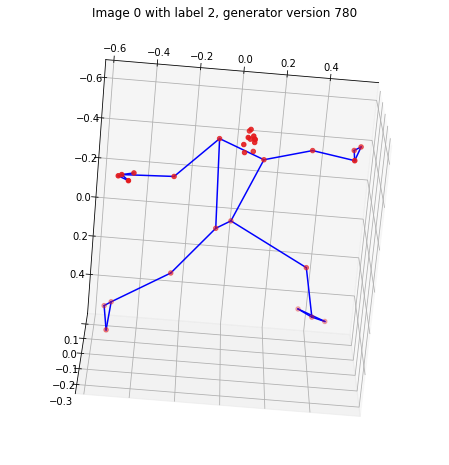

In [14]:
generate_coords_given_limb_lengths(calc_limb_lengths(np.squeeze(np_test, axis=0)), label, version=780, plot=True)